In [1]:
import os
import cv2
import glob
import random
import numpy as np
import imgaug as ia
import pandas as pd
import tensorflow as tf
from natsort import natsorted
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from skimage.transform import resize
from skimage.io import imread, imsave
from sklearn.metrics import confusion_matrix
from skimage import transform, filters, exposure

os.environ['CUDA_VISIBLE_DEVICES']='1'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
label2int = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
int2lable = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

In [3]:
#图片数据持久化，保存到本地，供下次直接调用 由于测试集比较大，本次只抽取训练集
def data_preprocessing(data_path, resize=True, img_rows=32, img_cols=32):
    if (os.path.exists(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        and os.path.exists(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy') 
        and os.path.exists(data_path + '/' + 'labels.npy')):
        print('data have already processed')
    else:
        ### Image preprocessing ###
        if resize == True:
            if not os.path.exists(data_path + "/trainResized"):
                os.makedirs(data_path + "/trainResized")
            if not os.path.exists(data_path + "/testResized"):
                os.makedirs(data_path + "/testResized")
        for set_type in ['train', 'test']:
            files = natsorted(glob.glob(data_path + '/' + set_type + '/*'))
            data = np.zeros((len(files), img_rows, img_cols, 3))
            for i, file_path in enumerate(files):
                '''
                img = imread(file_path, as_grey=True) #读入的图为[0, 1]图
                img_resized = resize(img, (img_rows, img_cols))
                data[i] = img_resized
                #Save image
                new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                imsave(new_name, img_resized)
                '''
                #利用opencv读取图片
                img = cv2.imread(file_path) #读入彩色图
                if resize == True:
                    img_resized = cv2.resize(img, (img_rows, img_cols))#读入的[0, 255]的图
                    data[i] = img_resized
                    #Save image
                    new_name = "/".join(file_path.split("/")[:-1] ) + "Resized/" + file_path.split("/")[-1]
                    cv2.imwrite(new_name, img_resized) 
                else:
                    data[i] = img
            #Add channel/filter dimension [222, 32, 32] => [222, 1, 32, 32]
            #train_img = np.stack(train_img)[..., None]
            #data = data[:, :, :, np.newaxis]
            data = data.astype('float32')
            data /= 255
            np.save(data_path + '/' + set_type + '_' + str(img_rows) +  '_' + str(img_cols) + '.npy', data)
        ### Labels preprocessing ###
        y_train = pd.read_csv(data_path + '/trainLabels.csv').values[:, 1]
        #Convert one-hot vectors
        Y_train = np.zeros((y_train.shape[0], len(np.unique(y_train))))
        for i in range(y_train.shape[0]):
            Y_train[i][label2int[y_train[i]]] = 1
        np.save(data_path + '/' + 'labels.npy', Y_train)
    X_train_all = np.load(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    Y_train_all = np.load(data_path + '/' + 'labels.npy')
    test_all = np.load(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '.npy')
    print('Finish')
    return X_train_all, Y_train_all, test_all

In [4]:
data_path = 'data'
X_train_all, Y_train_all, test_all = data_preprocessing(data_path, resize=False)

data have already processed
Finish


(50000, 32, 32, 3) (50000, 10)
(32, 32, 3)
bird
float32


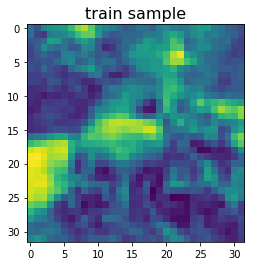

In [5]:
print(X_train_all.shape, Y_train_all.shape)
sample_id = 6
sample_x = X_train_all[sample_id]
print(X_train_all[sample_id].shape)
print(int2lable[np.argmax(Y_train_all[sample_id], axis=0)])
plt.title('train sample', size=16)
plt.imshow(sample_x[..., 0])
print(X_train_all.dtype)

In [6]:
### 划分验证集 ###
#打乱顺序
num_example=X_train_all.shape[0]
arr=np.arange(num_example)
np.random.shuffle(arr)
X_train_all=X_train_all[arr]
Y_train_all=Y_train_all[arr]

VALIDATION_SIZE = 1000    #验证集大小
x_val, y_val = X_train_all[:VALIDATION_SIZE], Y_train_all[:VALIDATION_SIZE]
x_train, y_train = X_train_all[VALIDATION_SIZE:], Y_train_all[VALIDATION_SIZE:]
print(x_train.shape, x_val.shape)
print(y_val[0].shape)
print(x_train[5][..., 0])

(49000, 32, 32, 3) (1000, 32, 32, 3)
(10,)
[[0.32156864 0.31764707 0.3254902  ... 0.23921569 0.21960784 0.20784314]
 [0.32156864 0.32156864 0.3254902  ... 0.23921569 0.21568628 0.20784314]
 [0.32156864 0.31764707 0.3254902  ... 0.24313726 0.21176471 0.20392157]
 ...
 [0.16862746 0.18039216 0.16470589 ... 0.3019608  0.2784314  0.27058825]
 [0.22352941 0.23921569 0.20392157 ... 0.35686275 0.34117648 0.33333334]
 [0.33333334 0.3372549  0.3137255  ... 0.38431373 0.36862746 0.35686275]]


In [22]:
def batch_augment(data):
    seq = iaa.Sequential([
        iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
        iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
        iaa.Flipud(0.5), #上下翻转
        #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
        iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-20, 20)),#旋转
        iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
        #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
        #iaa.AdditiveGaussianNoise(scale=(0,  0.05*255)),
        iaa.Sharpen(alpha=0.5),
        #iaa.Scale((0.5, 1.5))
    ],random_order=True)#每个batch中的Augmenters顺序不一样
    x_batch = seq.augment_images(data)
    return x_batch

cat


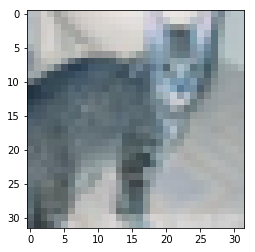

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

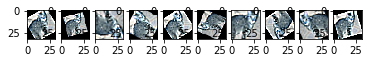

In [24]:
#展示数据扩增后的效果
imglist = []
#img = imread('data/train/3006.Bmp', as_grey=True)
sample_id = 1
sample_x = X_train_all[sample_id]
#img = cv2.imread('data/train/2212.Bmp', 0)
print(int2lable[np.argmax(Y_train_all[sample_id], axis=0)])
plt.imshow(sample_x)
plt.show()
imglist.append(sample_x)
for i in range(10):
    images_aug = batch_augment(imglist)
    plt.subplot(1, 10, i+1)
    plt.imshow(images_aug[0])
plt.show()

In [ ]:
#定义模型 lenet
def NIN(x, classnum, is_training):
    conv1 = tf.layers.conv2d(x, 192, 5, strides=1, padding='SAME')
    relu1 = tf.nn.relu(conv1)
    conv2 = tf.layers.conv2d(relu1, 160, 1, strides=1, padding='SAME')
    relu2 = tf.nn.relu(conv2)
    conv3 = tf.layers.conv2d(relu2, 96, 1, strides=1, padding='SAME')
    relu3 = tf.nn.relu(conv3)
    pool4 = tf.layers.max_pooling2d(relu3, pool_size=[3, 3], strides=2, padding='SAME')
        
    if is_training == True:
        pool4 = tf.layers.dropout(pool4, 0.5) 
    
    conv5 = tf.layers.conv2d(pool4, 192, 5, strides=1, padding='SAME')
    relu5 = tf.nn.relu(conv5)
    conv6 = tf.layers.conv2d(relu5, 192, 1, strides=1, padding='SAME')
    relu6 = tf.nn.relu(conv6)
    conv7 = tf.layers.conv2d(relu6, 192, 1, strides=1, padding='SAME')
    relu7 = tf.nn.relu(conv7)
    pool8 = tf.layers.max_pooling2d(relu7, pool_size=[3, 3], strides=2, padding='SAME')

    if is_training == True:
        pool8 = tf.layers.dropout(pool8, 0.5) 
    
    with tf.name_scope('layer2-pool'):
        pool2 = tf.layers.max_pooling2d(relu1, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.name_scope('layer3-conv'):
        conv3 = tf.layers.conv2d(pool2, 16, 5, strides=1, padding='VALID')
        relu3 = tf.nn.relu(conv3)
    with tf.name_scope('layer4-pool'):
        pool4 = tf.layers.max_pooling2d(relu3, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.name_scope('layer5-FC'):
        flatten = tf.reshape(pool4, [-1, 5*5*16])
        fc5 = tf.layers.dense(flatten, 120)
        relu5 = tf.nn.relu(fc5)
    with tf.name_scope('layer6-fc'):
        fc6 = tf.layers.dense(relu5, 84)
        relu6 = tf.nn.relu(fc6)
    with tf.name_scope('layer7-fc'):
        output = tf.layers.dense(relu6, classnum)
    return output